<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/calculate_petrofit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Warning:** this code uses full 400x400 images, so that download and curation should be performed for this code separately.

In [ ]:
#@title Download and curate table

from functools import partial
import operator
import numpy as np
import pandas as pd

print('DOWNLOADING TABLE')
!if [ ! -f "gz_decals_volunteers_5.parquet" ]; then wget https://zenodo.org/records/4573248/files/gz_decals_volunteers_5.parquet; fi

df = pd.read_parquet('gz_decals_volunteers_5.parquet')
working_columns = ['iauname',
                   'png_loc',
                   'smooth-or-featured_smooth_fraction',
                   'smooth-or-featured_total-votes',
                   'has-spiral-arms_yes_fraction',
                   'has-spiral-arms_total-votes',
                   'how-rounded_total-votes',
                   'how-rounded_round_fraction',
                   'how-rounded_in-between_fraction',
                   'how-rounded_cigar-shaped_fraction',
                   'disk-edge-on_total-votes',
                   'disk-edge-on_yes_fraction',
                   'disk-edge-on_no_fraction']


df = df[working_columns] # remove unnecessary columns
df['class'] = "" # add class column

lt = lambda x : np.isfinite and partial(operator.gt, x)
gt = lambda x : np.isfinite and partial(operator.lt, x)

conditions = {
    'has spiral arms': {'has-spiral-arms_yes_fraction': gt(0.8),
                        'has-spiral-arms_total-votes': gt(15)},
    'no spiral arms': {'has-spiral-arms_yes_fraction': lt(0.2),
                       'has-spiral-arms_total-votes': gt(15)},
    'round': {'how-rounded_round_fraction': gt(0.8),
              'how-rounded_total-votes': gt(10)},
    'inbetween': {'how-rounded_in-between_fraction': gt(0.8),
                  'how-rounded_total-votes': gt(10)},
    'cigar': {'how-rounded_cigar-shaped_fraction': gt(0.8),
              'how-rounded_total-votes': gt(10)},
    'edge on': {'disk-edge-on_yes_fraction': gt(0.8),
                'disk-edge-on_total-votes': gt(10)},
    'edge off': {'disk-edge-on_no_fraction': gt(0.8),
                 'disk-edge-on_total-votes': gt(10)},
    'smooth': {'smooth-or-featured_smooth_fraction': gt(0.8),
               'smooth-or-featured_total-votes': gt(10)},
    'featured': {'smooth-or-featured_smooth_fraction': lt(0.2),
                 'smooth-or-featured_total-votes': gt(10)}
}

for class_name, cond_rules in conditions.items():
  bool_arr = np.ones(len(df), dtype=bool)
  for col, condition_func in cond_rules.items():
    bool_arr &= condition_func(df[col])
  df.loc[bool_arr, 'class'] += f', {class_name}'

df['class'] = df['class'].str.lstrip(',')
df = df[df['class'] != ""] #remove unclassified

print('SAVING CURATED TABLE')
df.to_parquet('curated_dataset.parquet', index=False)

Downloading and curating images based on curated table. Please note, the procedure is quite slow (downloading 4 parts x 20 min per part). Images are NOT cropped. The result is archived in case you want to download it (final size will be approximately 1 Gb, the full original dataset is 4 parts x 20 Gb each).

In [ ]:
#@title Download and curate images
import zipfile
import pandas as pd
import os
from tqdm.auto import tqdm
import pathlib

df = pd.read_parquet('curated_dataset.parquet')
all_files = df['png_loc'].tolist()
all_files = [str(pathlib.Path(*pathlib.Path(f).parts[1:])) for f in all_files]

save_to_dir = 'curated_imgs'
if not os.path.exists(save_to_dir):
  os.makedirs(save_to_dir, exist_ok=True)

parts_urls = [
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part1.zip',
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part2.zip',
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part3.zip',
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part4.zip'
]

for part_idx, url in enumerate(parts_urls):
  print(f'PART {part_idx+1} of {len(parts_urls)}')
  _, filename = os.path.split(url)
  if not os.path.isfile(filename):
    !wget {url}
  if not os.path.isfile(filename):
    print(f'ERROR LOADING PART {part_idx+1}')
    continue
  print(f'UNZIPPING {filename}')
  with zipfile.ZipFile(filename) as z:
    files_in_part = list(set(all_files) & set(z.namelist()))
    with tqdm(total=len(files_in_part)) as progress:
      for filename1 in files_in_part:
        full_path = os.path.join(save_to_dir, filename1)
        path = pathlib.Path(full_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(full_path, 'wb') as f:
          f.write(z.read(filename1))
        progress.update()
  print('FILES EXTRACTED')
  !rm {filename}

from PIL import Image

# Define the cropping function
def crop_center(image, crop_width, crop_height):
    width, height = image.size
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    return image.crop((left, top, right, bottom))

def count_files(folder):
    count = 0
    for root, _, files in os.walk(folder):
        count += len(files)
    return count

#print('CROPPING IMAGES to 120x120')
#with tqdm(total=count_files(save_to_dir)) as progress:
#  for root, _, files in os.walk(save_to_dir):
#      for file in files:
#          file_path = os.path.join(root, file)
#          with Image.open(file_path) as img:
#            gray_img = img.convert("L")
#            cropped_img = crop_center(gray_img, 120, 120)
#            cropped_img.save(file_path)
#            progress.update()

print('ZIPPING just in case')
!zip -q -r curated_imgs.zip curated_imgs curated_dataset.parquet && echo "zipped" || echo "zip error"

print('PROCESSING COMPLETE!')

Install the libraries needed for processing

In [8]:
!pip install astropy==5.3.4
!pip install aplpy
!pip install petrofit

try:
  import astropy
  import petrofit
  import photutils
  from google.colab import output
  output.clear()
except:
  print('ERROR')
finally:
  print('COMPLETE')

COMPLETE


In [23]:
!rm -r out_images/
!rm petrofit_processed.parquet

Generate petrossian radii by `petrofit`. Results are saved to `output_imgs_folder` and `processed_table`.

The table is saved after each iteration, so that you can stop processing at any point.

================ processed 2 ===============
only the last result is shown, for all results see ./out_images


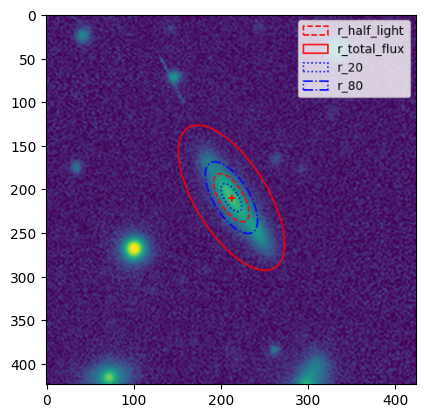

Deblending:   0%|          | 0/564 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
import astropy
import petrofit as pf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from photutils.utils import calc_total_error
from astropy.stats import sigma_clipped_stats
import os
import pandas as pd
from google.colab import output


original_table = 'curated_dataset.parquet'
processed_table = 'petrofit_processed.parquet'
input_imgs_folder = './curated_imgs'
output_imgs_folder = './out_images'


def reset_table(original_table, processed_table):
  df = pd.read_parquet(original_table)
  bootstrapped_df = df.sample(frac=1) # just shuffle
  bootstrapped_df = bootstrapped_df.assign(processed=False,
                                           r_80=0.0, theta=0.0, elong=0.0,
                                           position_X=0.0, position_Y=0.0)
  bootstrapped_df.reset_index()
  bootstrapped_df.to_parquet(processed_table)


def create_overlay(name, save_to):
  raw_image = Image.open(name)
  image = raw_image.convert("L")
  image_data = np.array(image).astype("float64")
  rms_fake = np.zeros_like(image_data)
  gain_fake= np.ones_like(image_data)

  err = calc_total_error(data=image_data, bkg_error=rms_fake, effective_gain=gain_fake)
  image_mean, image_median, image_stddev = sigma_clipped_stats(image_data, sigma=3)

  threshold = image_stddev * 3
  npixels = 2**2

  vmax = 0.05 # Use the image std as max and min of all plots
  vmin = - vmax

  cat, segm, segm_deblend = pf.make_catalog(image_data, threshold=threshold,
                                            deblend=True, npixels=npixels,
                                            contrast=0.00, plot=False,
                                            vmax=vmax, vmin=vmin)
  # Sort and select object of interest in the catalog
  sorted_idx_list = pf.order_cat(cat, key='area', reverse=True)
  idx = sorted_idx_list[0] # index 0 is largest
  source = cat[idx]  # get source from the catalog

  # Max aperture radius
  max_pix = image_data.shape[0]

  r_list = pf.make_radius_list(max_pix=max_pix, n=max_pix)

  # Photomerty
  flux_arr, area_arr, error_arr = pf.source_photometry(
      source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
      image_data, # Image as 2D array
      segm_deblend, # Deblended segmentation map of image
      r_list, # list of aperture radii
      # Options
      error=err, # Error image (optional)
      cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius
      bg_sub=True, # Subtract background
      sigma=3, sigma_type='clip', # Fit a 2D plane to pixels within 3 sigma of the mean
      plot=False # Show plot with max and min defined above
  )

  image_x_0, image_y_0 = pf.get_source_position(source)
  p = pf.Petrosian(r_list, area_arr, flux_arr, flux_err=error_arr, eta=0.2)

  r_80 = p._calculate_fraction_to_r(.8)[0]
  elong = pf.get_source_elong(source)
  position = pf.get_source_position(source)
  theta = pf.get_source_theta(source)
  parameters = {
    'r_80': r_80,
    'elong': elong,
    'position_X': position[0],
    'position_Y': position[1],
    'theta': theta
  }

  os.makedirs(os.path.dirname(save_to), exist_ok=True)

  h, w = image_data.shape[:2]
  fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
  ax.imshow(raw_image)
  p.imshow(position=position, elong=elong, theta=theta, lw=1.25)
  plt.legend()
  plt.axis("off")
  fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
  fig.canvas.draw()
  w, h = fig.canvas.get_width_height()
  buf, _ = fig.canvas.print_to_buffer()
  image_pil = Image.frombuffer("RGBA", (w, h), buf, "raw", "RGBA", 0, 1)
  image_pil.save(save_to, format="PNG")
  plt.close('all')
  return parameters


if not os.path.isfile(processed_table):
  reset_table(original_table, processed_table)
df = pd.read_parquet(processed_table)

counter = 0
for row in df.itertuples():
  file_path = df.at[row.Index, 'png_loc'].replace('dr5', input_imgs_folder)
  save_to_file_path = df.at[row.Index, 'png_loc'].replace('dr5', output_imgs_folder)
  if df.at[row.Index, 'processed']:
    print(f'skip already processed {file_path}')
    continue
  try:
    parameters = create_overlay(file_path, save_to_file_path)
  except Exception as e:
    print(f"Error occurred for {file_path}: {e}")
    continue
  for k,v in parameters.items():
    df.at[row.Index, k] = v
  df.at[row.Index, 'processed'] = True
  df.to_parquet(processed_table)
  output.clear()
  counter += 1
  print(f'================ processed {counter} ===============')
  print(f'only the last result is shown, for all results see {output_imgs_folder}')
  saved_img = Image.open(save_to_file_path)
  plt.imshow(saved_img)
  plt.draw()
  plt.show()
  print('===============================')


In [6]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


processed_table = 'petrofit_processed.parquet'
overlay_images = './curated_imgs'
save_folder = './overlayed'
color = 'red'


def draw_ellipse(mean_X, mean_Y, s_std, y_std, angle, n_std=1, ax=None):
  t = np.linspace(0, 2 * np.pi, 100)  # Parametric angle
  circle = np.array([np.cos(t), np.sin(t)])  # Unit circle points

  # Scale circle by standard deviations (to form an ellipse)
  scale_matrix = np.diag([s_std, y_std])
  ellipse = scale_matrix @ circle  # Stretch unit circle to ellipse

  # Rotation matrix
  R = np.array([[np.cos(angle), -np.sin(angle)],
                [np.sin(angle), np.cos(angle)]])

  # Rotate the ellipse
  rotated_ellipse = R @ ellipse

  # Shift to the mean
  x_ellipse = rotated_ellipse[0] * n_std + mean_X
  y_ellipse = rotated_ellipse[1] * n_std + mean_Y

  # Plot the ellipse
  if ax is None:
    fig, ax = plt.subplots()

  ax.plot(x_ellipse, y_ellipse, color=color)


df = pd.read_parquet(processed_table)
filtered_df = df[df['processed'] == True]
with tqdm(total=len(filtered_df)) as progress:
  for row in filtered_df.itertuples():
    file_path = filtered_df.at[row.Index, 'png_loc'].replace('dr5', overlay_images)
    save_to = filtered_df.at[row.Index, 'png_loc'].replace('dr5', save_folder)
    raw_image = Image.open(file_path)
    fig, ax = plt.subplots()
    ax.imshow(raw_image)
    a = filtered_df.at[row.Index, 'r_80']
    b = a / filtered_df.at[row.Index, 'elong']
    draw_ellipse(filtered_df.at[row.Index, 'position_X'],
                filtered_df.at[row.Index, 'position_Y'], a, b,
                filtered_df.at[row.Index, 'theta'], n_std=1, ax=ax)
    plt.axis("off")
    os.makedirs(os.path.dirname(save_to), exist_ok=True)
    plt.savefig(save_to, bbox_inches="tight", pad_inches=0)
    plt.close('all')
    progress.update()


  0%|          | 0/13 [00:00<?, ?it/s]

See statistics on `r_80`. Image size after crop is expected to be approximately twice as large.

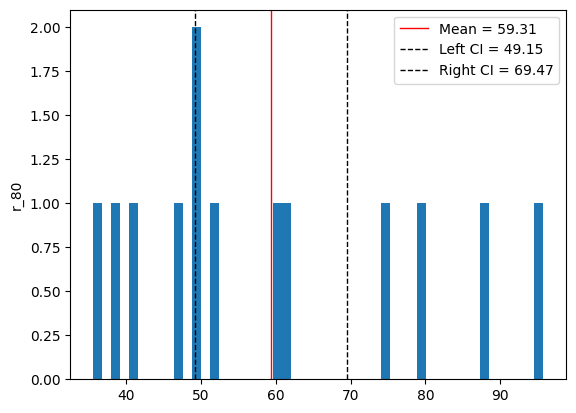

mean =  59.31407820025542  ±  5.183381753000062


In [9]:
import numpy as np
import pandas as pd


processed_table = 'petrofit_processed.parquet'


def show_stats(t):
  mean = np.mean(t)
  std = np.std(t)
  n = len(t)

  # Compute standard error of the mean (SEM)
  sem = std / np.sqrt(n)

  # Compute 95% confidence interval
  z_95 = 1.96  # z-score for 95% confidence
  margin_error = z_95 * sem
  left_ci = mean - margin_error
  right_ci = mean + margin_error

  plt.hist(t, bins=50)
  plt.axvline(mean, color='red', linestyle='solid', linewidth=1, label=f'Mean = {mean:.2f}')
  plt.axvline(left_ci, color='black', linestyle='dashed', linewidth=1, label=f'Left CI = {left_ci:.2f}')
  plt.axvline(right_ci, color='black', linestyle='dashed', linewidth=1, label=f'Right CI = {right_ci:.2f}')
  plt.ylabel("r_80")
  plt.legend()
  plt.show()
  print("mean = ", mean, " ± ",sem)

df = pd.read_parquet(processed_table)
filtered_df = df[df['processed'] == True]
show_stats(filtered_df["r_80"])
